Анализ результатов АБ-теста

В данном задании нужно будет:

- проанализировать АБ тест, проведённый на реальных пользователях Яндекса;
- подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами;
- определить характер этих изменений и практическую значимость вводимого изменения;
- понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение).

Описание данных:

- userID: уникальный идентификатор пользователя
- browser: браузер, который использовал userID
- slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
- n_clicks: количество кликов, которые пользоваль совершил за n_queries
- n_queries: количество запросов, который совершил userID, пользуясь браузером browser
- n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [2]:
from scipy import stats
import scipy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
ab = pd.read_csv('ab_browser_test.csv')
ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566134 entries, 0 to 566133
Data columns (total 6 columns):
userID              566134 non-null int64
browser             566134 non-null object
slot                566134 non-null object
n_clicks            566134 non-null int64
n_queries           566134 non-null int64
n_nonclk_queries    566134 non-null int64
dtypes: int64(4), object(2)
memory usage: 25.9+ MB


In [4]:
ab.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [5]:
exp = ab[ab.slot=='exp']
control = ab[ab.slot=='control']

In [6]:
exp.shape

(281580, 6)

In [7]:
control.shape

(284554, 6)

Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.

In [8]:
exp_click_num = exp.n_clicks.sum()
control_click_num = control.n_clicks.sum()

In [9]:
exp_click_num

3261823

In [10]:
control_click_num

3210027

In [11]:
proportion_clicks = (exp_click_num/control_click_num - 1) * 100

In [12]:
proportion_clicks

1.6135689824415822

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.

In [13]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [14]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [15]:
np.random.seed(0)

exp_n_clicks = np.array(exp.n_clicks.values)
control_n_clicks = np.array(control.n_clicks.values)

exp_median_scores = np.median(get_bootstrap_samples(exp_n_clicks, 500), axis=1)
control_median_scores = np.median(get_bootstrap_samples(control_n_clicks, 500), axis=1)

In [16]:
print("95% confidence interval for Exp group:",  stat_intervals(exp_median_scores, 0.05))
print("95% confidence interval for Control group:",  stat_intervals(control_median_scores, 0.05))

95% confidence interval for Exp group: [5. 5.]
95% confidence interval for Control group: [4. 4.]


In [17]:
np.random.seed(0)

exp_mean_scores = np.mean(get_bootstrap_samples(exp_n_clicks, 500), axis=1)
control_mean_scores = np.mean(get_bootstrap_samples(control_n_clicks, 500), axis=1)

print("95% confidence interval for Exp group:",  stat_intervals(exp_mean_scores, 0.05))
print("95% confidence interval for Control group:",  stat_intervals(control_mean_scores, 0.05))

95% confidence interval for Exp group: [11.50789349 11.6588664 ]
95% confidence interval for Control group: [11.20668696 11.35347509]


In [18]:
delta_mean = list(map(lambda x: x[0] - x[1], zip(exp_mean_scores, control_mean_scores)))
delta_median = list(map(lambda x: x[0] - x[1], zip(exp_median_scores, control_median_scores)))

In [19]:
print('Conf. int. delta mean:', stat_intervals(delta_mean, 0.05))
print('Conf. int. delta median:', stat_intervals(delta_median, 0.05))

Conf. int. delta mean: [0.19960335 0.40496719]
Conf. int. delta median: [1. 1.]


Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах.

t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Для простоты рассмотрим одновыборочный t-критерий. Чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

- среднее значение в выборке было распределено нормально N(μ,σ2n)
- несмещенная оценка дисперсии c масштабирующим коэффициентом была распределена по хи-квадрат c n−1 степенями свободы χ2(n−1)

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия.

Для этого

- получим из данных n_boot_samples псевдовыборок.
- по каждой из этих выборок посчитаем среднее и сумму квадратов отклонения от выборочного среднего
- для получившегося вектора средних значений из n_boot_samples построим q-q plot с помощью scipy.stats.probplot для нормального распределения
- для получившегося вектора сумм квадратов отклонения от выборочного среднего построим qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения

In [20]:
np.random.seed(0)
n_boot_samples = 500

control_samples = get_bootstrap_samples(control_n_clicks, n_boot_samples)

In [21]:
control_boot_mean = np.mean(control_samples, axis=1)
control_boot_chi_squared = np.var(control_samples,axis=1)

Text(0.5, 1.0, 'Probability plot for means')

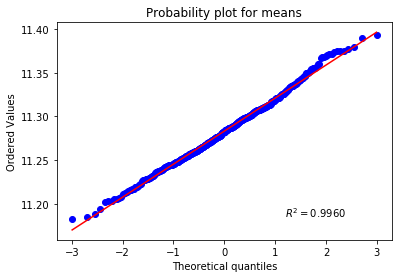

In [42]:
stats.probplot(control_boot_mean, plot=plt, rvalue=True)
plt.title('Probability plot for means')

Text(0.5, 1.0, 'Probability plot for variances')

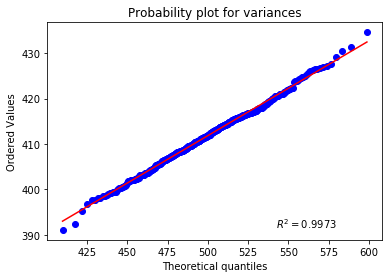

In [43]:
stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(control_boot_chi_squared.shape[0]-1), plot=plt, rvalue=True)
plt.title('Probability plot for variances')

In [24]:
stats.ttest_ind(exp_n_clicks,control_n_clicks,equal_var=False)

Ttest_indResult(statistic=5.63071804102796, pvalue=1.795455499781595e-08)

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [51]:
user_n_click_exp = ab[ab['slot']=='exp'].groupby(by='userID')['n_clicks'].agg(np.sum)

In [52]:
user_n_click_control = ab[ab['slot']=='control'].groupby(by='userID')['n_clicks'].agg(np.sum)

In [53]:
stats.mannwhitneyu(user_n_click_exp, user_n_click_control)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с \alpha=0.05α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [91]:
browsers = ab.browser.unique()
browsers

array(['Browser #2', 'Browser #4', 'Browser #14', 'Browser #17',
       'Browser #20', 'Browser #22'], dtype=object)

In [99]:
pvals = []
for i in browsers:
    pval = stats.mannwhitneyu(exp[exp.browser == i].n_clicks, control[control.browser == i].n_clicks, alternative='two-sided').pvalue
    pvals.append(pval)

In [100]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [101]:
rej, pval_corr = multipletests(pvals, alpha=0.05/browsers.shape[0], method='holm')[:2]

In [104]:
for i, br in enumerate(browsers):
    print(br, end=' ')
    print('p-value = %.4f' % pvals[i], end=' ')
    print('p-value corr = %.4f' % pval_corr[i])

Browser #2 p-value = 0.0545 p-value corr = 0.2724
Browser #4 p-value = 0.8152 p-value corr = 1.0000
Browser #14 p-value = 0.0000 p-value corr = 0.0000
Browser #17 p-value = 0.0748 p-value corr = 0.2992
Browser #20 p-value = 0.9073 p-value corr = 1.0000
Browser #22 p-value = 0.5148 p-value corr = 1.0000


Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения.

In [111]:
exp_props = []
control_props = []
for i in browsers:
    exp_prop = np.sum(exp[exp.browser == i].n_nonclk_queries)/np.sum(exp[exp.browser == i].n_queries)*100
    control_prop = np.sum(control[control.browser == i].n_nonclk_queries)/np.sum(control[control.browser == i].n_queries)*100
    exp_props.append(exp_prop)
    control_props.append(control_prop)

In [112]:
for i, br in enumerate(browsers):
    print(br, end=' ')
    print('exp props = %.4f' % exp_props[i], end=' ')
    print('/', end=' ')
    print('control props = %.4f' % control_props[i])

Browser #2 exp props = 44.9827 / control props = 45.9627
Browser #4 exp props = 45.1429 / control props = 46.9709
Browser #14 exp props = 43.7556 / control props = 57.5904
Browser #17 exp props = 36.9374 / control props = 36.2994
Browser #20 exp props = 38.9774 / control props = 40.5405
Browser #22 exp props = 39.8539 / control props = 40.5940
